In [16]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

np.set_printoptions(suppress=True)

from helpers import build_distance_matrix
from gaussian_process import batched_gaussian_process
from priors import diffusion_prior_gp, length_scale_prior
from diffusion import simple_batch_diffusion

In [17]:
import tensorflow_probability as tfp
tfd = tfp.distributions
tfpl = tfp.layers

In [18]:
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.models import Sequential, Model

In [19]:
from tqdm.notebook import tqdm

# Constants

In [20]:
T = 100
DIST_MAT = build_distance_matrix(T)
AMPLITUDES = [0.25, 0.25, 0.15]
BATCH_SIZE = 32
DEV_SIZE = 3
TEST_SIZE = 10
TRAIN_SIZE = 10000
EPOCHS = 50

# Dev

In [21]:
theta0 = diffusion_prior_gp(DEV_SIZE, n_cond=1)
eta = length_scale_prior(DEV_SIZE, 3)
theta_t = batched_gaussian_process(theta0, DIST_MAT, eta, amplitudes=AMPLITUDES)

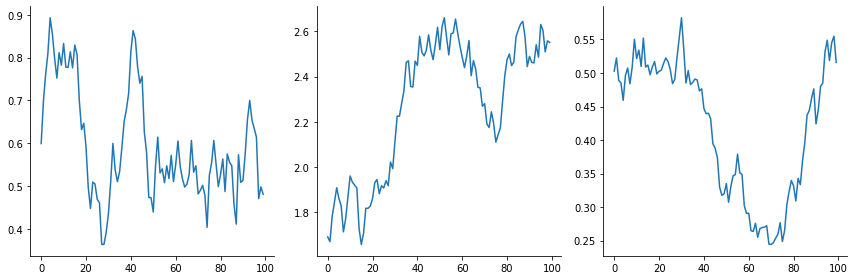

In [22]:
which = np.random.randint(0, DEV_SIZE)
f, axarr = plt.subplots(1, 3, figsize=(12, 4))
for i in range(3):
    axarr[i].plot(theta_t[which, :, i])
    sns.despine(ax=axarr[i])
f.tight_layout()

# Test Training

## Network

In [23]:
network = Sequential([
    LSTM(128, return_sequences=True),
    LSTM(128, return_sequences=True),
    Dense(128, activation='elu'),
    Dense(tfpl.MultivariateNormalTriL.params_size(6)),
    tfpl.MultivariateNormalTriL(6)
])
optimizer = tf.keras.optimizers.Adam()

## Data

In [26]:
theta0 = diffusion_prior_gp(TRAIN_SIZE, n_cond=1)
eta = length_scale_prior(TRAIN_SIZE, 3).astype(np.float32)
theta_t = batched_gaussian_process(theta0, DIST_MAT, eta, amplitudes=AMPLITUDES).astype(np.float32)
eta_t = np.stack([eta] * T, axis=1)
rt = simple_batch_diffusion(theta_t).astype(np.float32)
params_t = np.concatenate([theta_t, eta_t], axis=-1)
dataset = tf.data.Dataset.from_tensor_slices((rt, params_t)).shuffle(1024).batch(BATCH_SIZE)

In [28]:
params_mean = params_t.mean(axis=(0, 1))
params_std = params_t.std(axis=(0, 1))

In [31]:
def nll(y_true, y_pred):
    return tf.reduce_mean(-y_pred.log_prob(y_true))

In [33]:
def train_epoch(network, optimizer, dataset, batch_size, p_bar, mmd_weight=0.1):
    """ Helper function for one simulation epoch. """
    
    losses = []
    for bi, (data, params) in enumerate(dataset):
        with tf.GradientTape() as tape:
            params_pred = network(data)
            params_z = (params - params_mean) / params_std
            loss = nll(params_z, params_pred)
            
        # Backprop step
        g = tape.gradient(loss, network.trainable_variables)
        optimizer.apply_gradients(zip(g, network.trainable_variables))
        losses.append(loss.numpy())

        # Update progress bar
        p_bar.set_postfix_str("Batch {},Loss: {:.3f},Avg.Loss: {:.3f}"
                              .format(bi+1, loss.numpy() , np.mean(losses)))
        p_bar.update(1)
    return losses

In [35]:
# # Train
# losses = []
# for ep in range(1, EPOCHS+1):
#     with tqdm(total=len(dataset), desc=f'Training Epoch {ep}') as p_bar:
#         loss_ep = train_epoch(network, optimizer, dataset, BATCH_SIZE, p_bar)
#         losses.append(loss_ep)

# Validation

## Gen Test Data

In [36]:
theta0 = diffusion_prior_gp(TEST_SIZE, n_cond=1)
eta = length_scale_prior(TEST_SIZE, 3)
theta_test = batched_gaussian_process(theta0, DIST_MAT, eta, amplitudes=AMPLITUDES)
rt_test = simple_batch_diffusion(theta_test).astype(np.float32)

## Predict

In [37]:
theta_preds = network(rt_test)
theta_means = theta_preds.mean() * params_std + params_mean
theta_stds = theta_preds.stddev() * params_std

##  Visualize Predictions Over Time

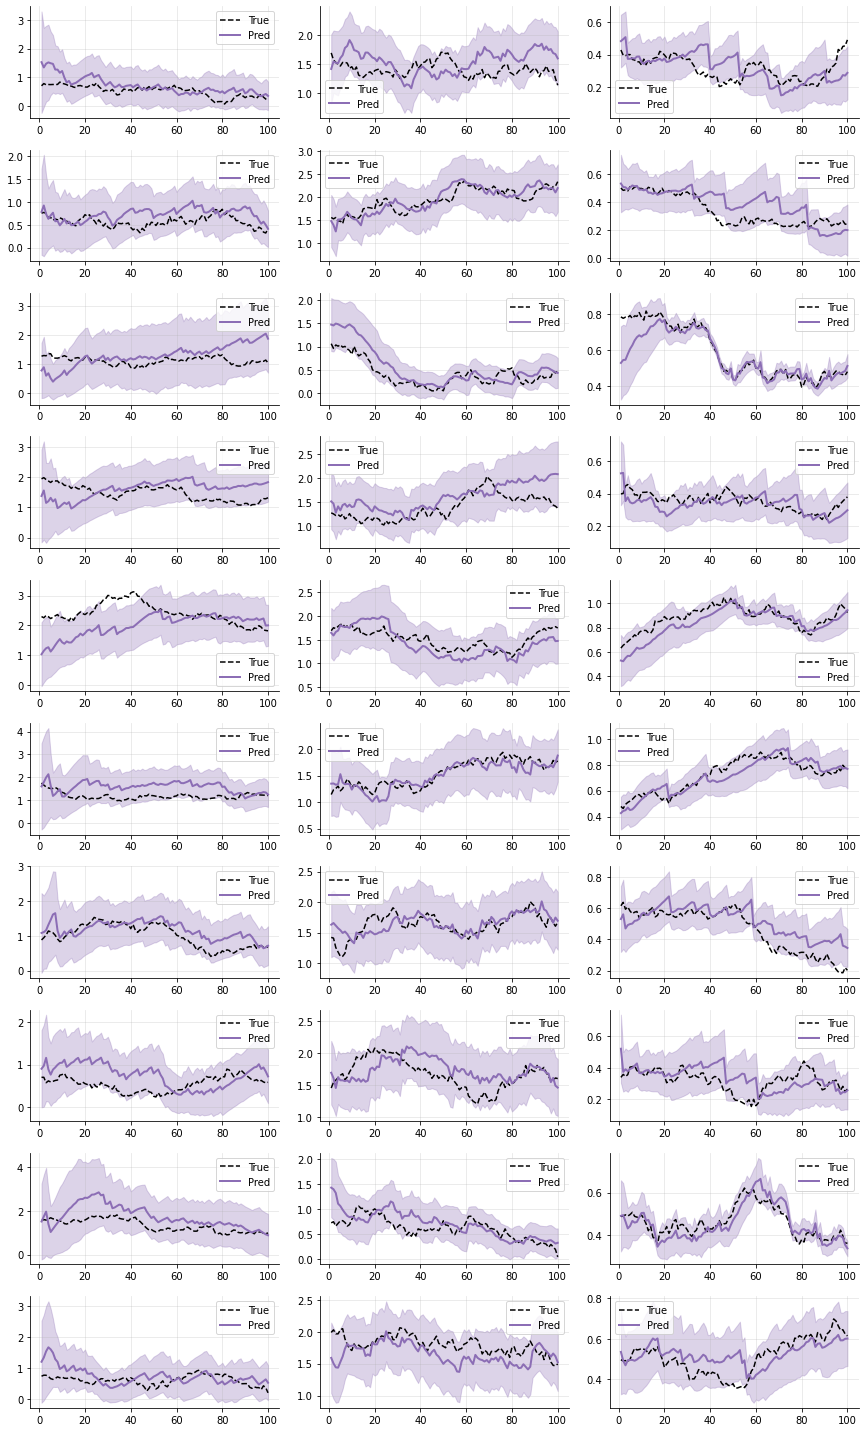

In [38]:
f, axarr = plt.subplots(TEST_SIZE, 3, figsize=(12, 20))
std_mul = 2
time = np.arange(1, theta_test.shape[1]+1)
for j in range(TEST_SIZE):
    for i in range(3):
        ax = axarr[j, i]
        ax.plot(time, theta_test[j, :, i], label='True', color='black', linestyle='dashed')
        ax.plot(time, theta_means[j, :, i], label='Pred', lw=2, color='#8c6eb5')
        ax.fill_between(time, 
                        theta_means[j, :, i] + std_mul * theta_stds[j, :, i], 
                        theta_means[j, :, i] - std_mul * theta_stds[j, :, i], color='#8c6eb5', alpha=0.3)
        sns.despine(ax=ax)
        ax.legend()
        ax.grid(alpha=0.3)
f.tight_layout()

## Visualize Slices

In [39]:
VAL_SIZE = 300
theta0 = diffusion_prior_gp(VAL_SIZE, n_cond=1)
eta = length_scale_prior(VAL_SIZE, 3)
theta_test = batched_gaussian_process(theta0, DIST_MAT, eta, amplitudes=AMPLITUDES)
rt_test = simple_batch_diffusion(theta_test).astype(np.float32)
SLICE_POINTS = [2, 50, 100]

In [42]:
theta_preds = network(rt_test)
theta_means = theta_preds.mean().numpy() * params_std + params_mean
theta_stds = theta_preds.stddev().numpy() * params_std

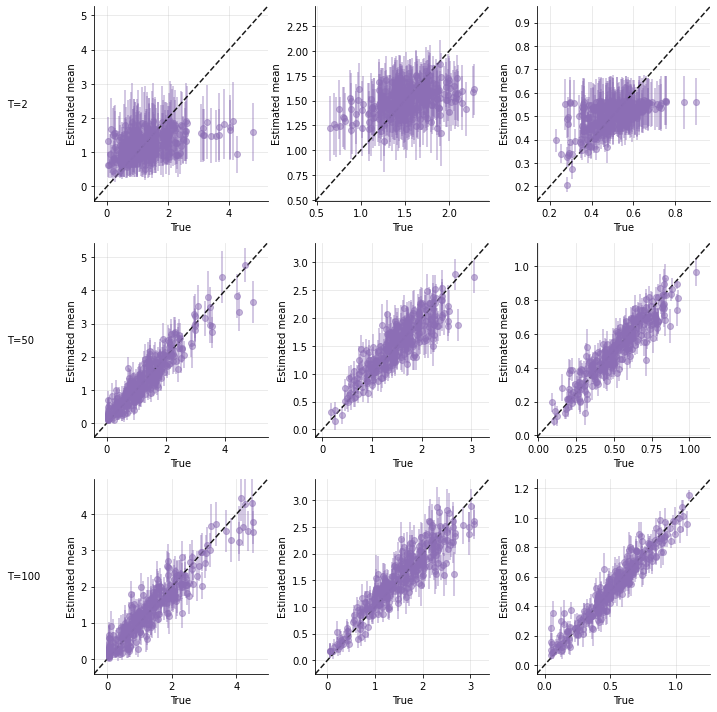

In [43]:
f, axarr = plt.subplots(len(SLICE_POINTS), 3, figsize=(10, 10))
for j in range(len(SLICE_POINTS)):
    for i in range(3):
        ax = axarr[j, i]
        true = theta_test[:, SLICE_POINTS[j]-1, i]
        pred = theta_means[:, SLICE_POINTS[j]-1, i]
        std = theta_stds[:, SLICE_POINTS[j]-1, i]
        ax.errorbar(true, pred, yerr=std, fmt='o', alpha=0.5, color='#8c6eb5')
        # ax.scatter(true, pred, color='#8c6eb5')
        sns.despine(ax=ax)
        ax.grid(alpha=0.3)
        
        lower = min(true.min(), pred.min())
        upper = max(true.max(), pred.max())
        eps = (upper - lower) * 0.1
        ax.set_xlim([lower - eps, upper + eps])
        ax.set_ylim([lower - eps, upper + eps]) 
        ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [ax.get_ylim()[0], ax.get_ylim()[1]], 
                 color='black', alpha=0.9, linestyle='dashed')
        ax.set_xlabel('True')
        ax.set_ylabel('Estimated mean')
        if i == 0:
            ax.text(-0.5, 0.5, f'T={SLICE_POINTS[j]}',
            horizontalalignment='left',
            verticalalignment='center',
            transform=ax.transAxes)
f.tight_layout()